In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import pdb
import math
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
np.seterr(all='raise')
special.seterr(all='raise')
warpSize = 32
blockSize = 1024
from patch_geo_func import *

In [3]:
den_area = 850 # mm^2 O'Kusky 1982 for the neuronal density we use later  
# exp. measurement 
darea = lambda E: 140*(0.78+E)**(-2.2) # Van Essen 1984 Vision Research "standard" map, 5232x1024
area_slice = lambda E: np.pi*E*darea(E)
# model fit
a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
s1 = 0.76
s2 = 0.1821
model_block = lambda p, e: model_block_ep(e,p,k,a,b,s1,s2)

In [4]:
# total v1 size
r = integrate.quad(area_slice,0,90)
v1_size_exp = r[0]
r = integrate.dblquad(model_block,0,90,-pi/2,pi/2)
v1_size_model = r[0]
print(f'Size of V1 = {v1_size_exp} (exp.) ~ {v1_size_model} (model) ({v1_size_model*100/v1_size_exp}%) mm^2')
ecc = 2.0
r = integrate.quad(area_slice,0,ecc)
area_exp = r[0]
r = integrate.dblquad(model_block,0,ecc,-np.pi/2,np.pi/2)
area_model = r[0]
print(f'A patch of v1 from eccentricity {0} to {ecc} yields {area_exp} (exp.) ~ {area_model} (model) ({area_model*100/area_exp}%) mm^2')
model_ratio = den_area/v1_size_model

Size of V1 = 1034.654752772809 (exp.) ~ 1036.1577689972858 (model) (100.14526741605823%) mm^2
A patch of v1 from eccentricity 0 to 2.0 yields 217.36359970075964 (exp.) ~ 216.71178952994552 (model) (99.70012910546593%) mm^2


In [5]:
## O'Kusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea
# L4
surface_den_L4Cbeta = 30000*model_ratio # per mm^2
print(f'rescale density in O\'Kusky 1982 to {surface_den_L4Cbeta} to keep constant number of neurons')
assert(30000*den_area == surface_den_L4Cbeta*v1_size_model)
_n_L4Cbeta = area_model*surface_den_L4Cbeta # 32^4 * 10 ~ 10.4 million
n_L4Cbeta = int((_n_L4Cbeta+blockSize-1)//blockSize*blockSize)
nblock_L4Cbeta = n_L4Cbeta//blockSize
block_area_L4Cbeta = area_model/nblock_L4Cbeta
L4_area = area_model
print(f'Rounding #neurons in L4Cbeta from {_n_L4Cbeta} to {n_L4Cbeta} = {nblock_L4Cbeta} x {blockSize}, area per block = {block_area_L4Cbeta} mm^2')
# L23
surface_den_L23 = 18000*model_ratio # per mm^2
print(f'rescale density in O\'Kusky 1982 to {surface_den_L23} to keep constant number of neurons')
_n_L23 = area_model*surface_den_L23
n_L23 = int((_n_L23+blockSize-1)//blockSize*blockSize)
nblock_L23 = n_L23//blockSize
block_area_L23 = area_model/nblock_L23
L23_area = area_model
print(f'Rounding #neurons in L2/3 from {_n_L23} to {n_L23} = {nblock_L23} x {blockSize}, area per block = {block_area_L23} mm^2')

rescale density in O'Kusky 1982 to 24610.15181566119 to keep constant number of neurons
Rounding #neurons in L4Cbeta from 5333310.040575574 to 5334016 = 5209 x 1024, area per block = 0.041603338362439145 mm^2
rescale density in O'Kusky 1982 to 14766.091089396714 to keep constant number of neurons
Rounding #neurons in L2/3 from 3199986.0243453444 to 3200000 = 3125 x 1024, area per block = 0.06934777264958257 mm^2


characteristic block width = 0.20396896421377234
100.000% slice #70

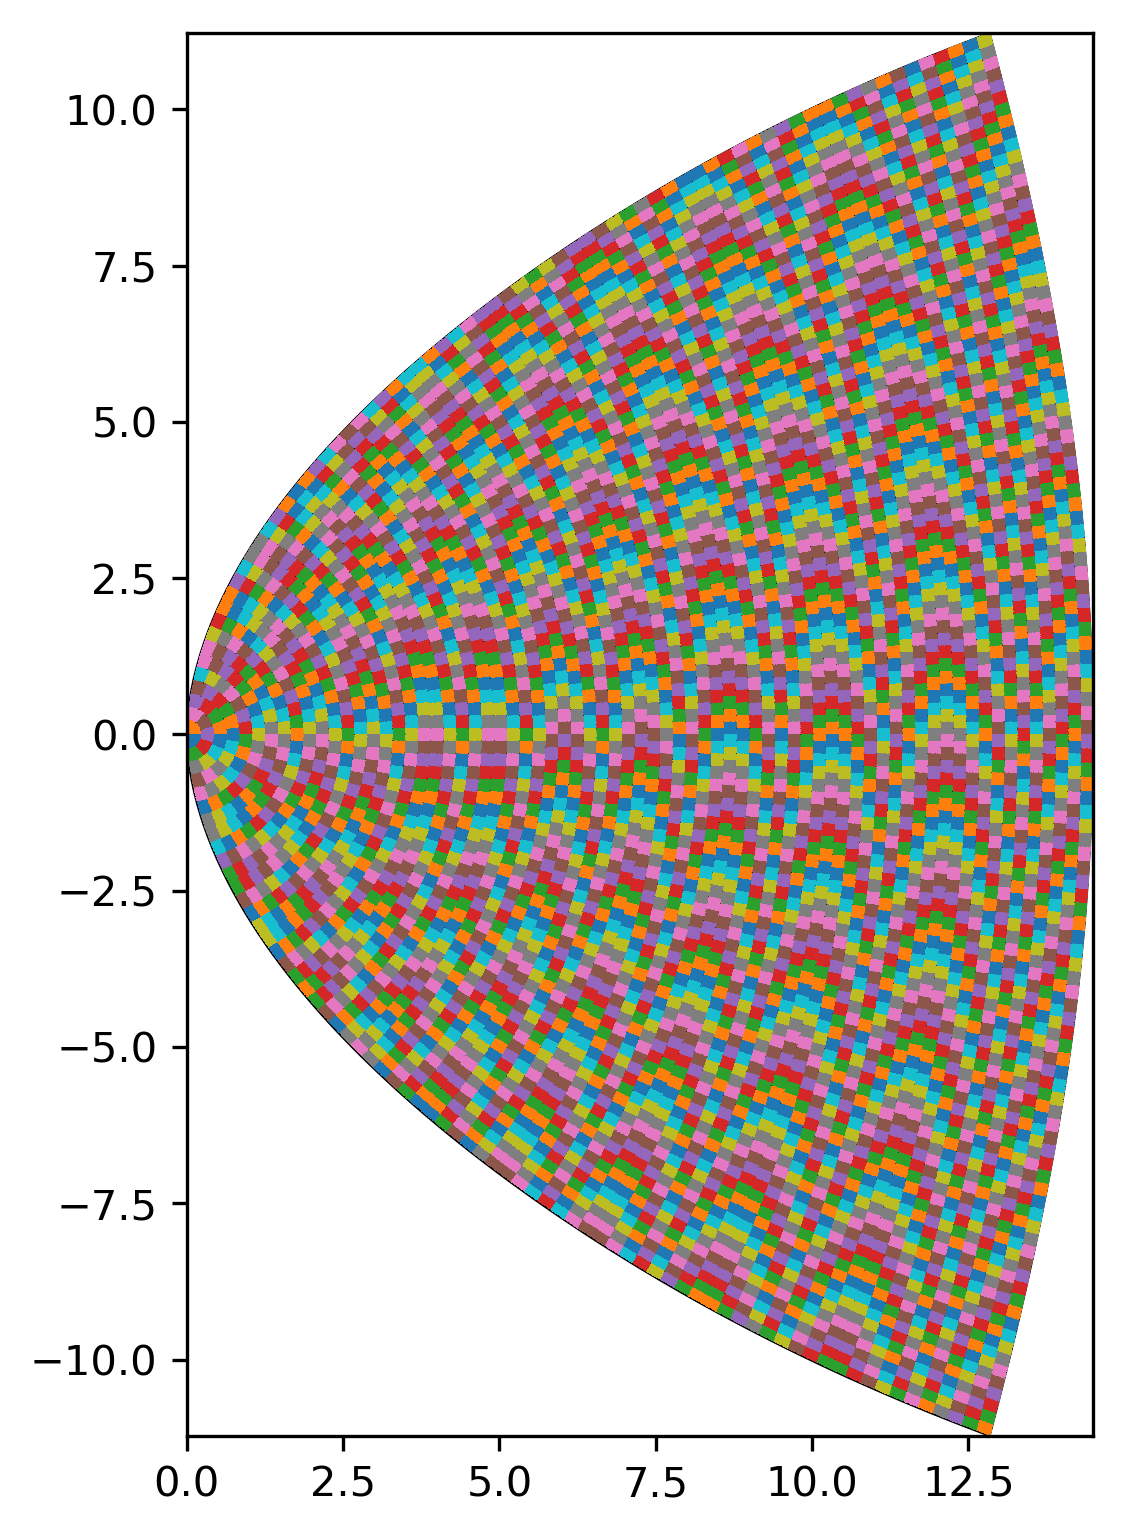

In [10]:
fig, pos = plot_patch(a,b,k,ecc,block_area_L4Cbeta,nblock_L4Cbeta,ax=None,skip=602,s1=0.76,s2=0.1821,ret_fig=True,blockSize=1024)
#fig, pos = plot_patch(a,b,k,ecc,L4_area/1024,1024,ax=None,skip=602,s1=0.76,s2=0.1821,ret_fig=True,blockSize=32)

In [1]:
fig.savefig('test_density2.png', dpi = 600)
pos.tofile('test_3d_pos.bin')

NameError: name 'fig' is not defined

In [35]:
# test x-derivative
x0 = lambda e, p: x_ep(e,p,k,a,b,s1,s2)
polar = np.pi/2
ecc = 1.7
print(x0(ecc, polar)-k*np.log(a/b))
dx_e = lambda e: d_x_e(e,0,k,a,b,s1,s2)
dx_p = lambda p: d_x_p(ecc,p,k,a,b,s1,s2)
r = integrate.quad(dx_e, 0, ecc)
print(r[0])
x1 = r[0]
r = integrate.quad(dx_p, 0, polar)
print(r[0])
x1 = x1 + r[0]
print(x1)

11.8148526764
13.437883263249457
-1.6230305868270465
11.814852676422412


In [37]:
# test y-derivative
y0 = lambda e, p: y_ep(e,p,k,a,b,s1,s2)
polar = np.pi/4
ecc = 1.7
print(y0(ecc, polar))
dy_e = lambda e: d_y_e(e,0,k,a,b,s1,s2)
dy_p = lambda p: d_y_p(ecc,p,k,a,b,s1,s2)
r = integrate.quad(dy_e, 0, ecc)
print(r[0])
y1 = r[0]
r = integrate.quad(dy_p, 0, polar)
print(r[0])
y1 = y1 + r[0]
print(y1)

In [55]:
d = np.array([1,2,3])
d = np.flip(d)

TypeError: flip() missing 1 required positional argument: 'axis'

In [54]:
d

array([3, 2, 1])